# Overview
Initial data-load code and submit code take from this awesome kernel https://www.kaggle.com/kmader/baseline-u-net-model-part-1 



## Forked the following kernel:
https://www.kaggle.com/windsurfer/baseline-u-net-on-pytorch

Plan:
Implement MobileUNet: introduce DW separable conv to make it lighter

In [1]:
BATCH_SIZE = 16
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from skimage.util.montage import montage2d as montage
import cv2
import random
from datetime import datetime
import json
import gc

import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
import torch.backends.cudnn as cudnn
import torch.backends.cudnn
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision.transforms import ToTensor, Normalize, Compose



from tqdm import tqdm
from pathlib import Path

from skimage.morphology import label

ship_dir = '../input/'
train_image_dir = os.path.join(ship_dir, 'train_v2')
test_image_dir = os.path.join(ship_dir, 'test_v2')
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def multi_rle_encode(img):
    labels = label(img)
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.int16)
    #if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

def mask_overlay(image, mask, color=(0, 1, 0)):
    """
    Helper function to visualize mask on the top of the image
    """
    mask = np.dstack((mask, mask, mask)) * np.array(color)
    weighted_sum = cv2.addWeighted(mask, 0.5, image, 0.5, 0.)
    img = image.copy()
    ind = mask[:, :, 1] > 0
    img[ind] = weighted_sum[ind]    
    return img

def imshow(img, mask, title=None):
    """Imshow for Tensor."""
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    mask = mask.numpy().transpose((1, 2, 0))
    mask = np.clip(mask, 0, 1)
    fig = plt.figure(figsize = (6,6))
    plt.imshow(mask_overlay(img, mask))
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

In [2]:
masks = pd.read_csv(os.path.join(ship_dir,
                                 'train_ship_segmentations_v2.csv'))
#masks = masks.iloc[10000:12000]
print(masks.shape[0], 'masks found')
print(masks['ImageId'].value_counts().shape[0], 'unique images found')
#masks.head()

231723 masks found
192556 unique images found


# Undersample Empty Images
Here we undersample the empty images to get a better balanced group with more ships to try and segment

In [3]:
masks = masks.drop(masks[masks.EncodedPixels.isnull()].sample(70000,random_state=42).index)

# Split into training and validation groups
We stratify by the number of boats appearing so we have nice balances in each set

In [4]:
from sklearn.model_selection import train_test_split
unique_img_ids = masks.groupby('ImageId').size().reset_index(name='counts')
train_ids, valid_ids = train_test_split(unique_img_ids, 
                 test_size = 0.05, 
                 stratify = unique_img_ids['counts'],
                 random_state=42
                )
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

153636 training masks
8087 validation masks


In [5]:
train_df['counts'] = train_df.apply(lambda c_row: c_row['counts'] if 
                                    isinstance(c_row['EncodedPixels'], str) else
                                    0, 1)
valid_df['counts'] = valid_df.apply(lambda c_row: c_row['counts'] if 
                                    isinstance(c_row['EncodedPixels'], str) else
                                    0, 1)


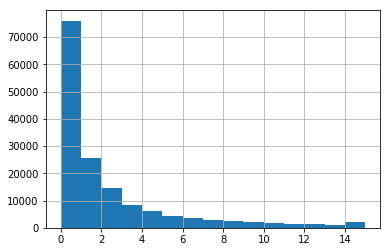

In [6]:
train_df['counts'].hist(bins = 15)

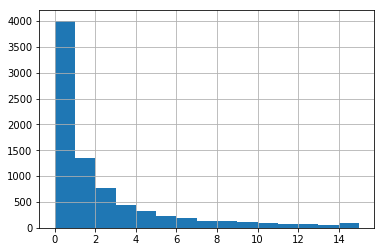

In [7]:
valid_df['counts'].hist(bins = 15)

In [8]:
print(train_df.ImageId.nunique(), 'unique images in train set')

116428 unique images in train set


In [9]:
print(valid_df.ImageId.nunique(),'unique images in test set')

6128 unique images in test set


## Dataset class for PyTorch dataloader

In [10]:

class ShipDataset(Dataset):
    def __init__(self, in_df, transform=None, mode='train'):
        grp = list(in_df.groupby('ImageId'))
        self.image_ids =  [_id for _id, _ in grp] 
        self.image_masks = [m['EncodedPixels'].values for _,m in grp]
        self.transform = transform
        self.mode = mode
        self.img_transform = Compose([
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.image_ids)
               
    def __getitem__(self, idx):
        img_file_name = self.image_ids[idx]
        if self.mode == 'train':
            rgb_path = os.path.join(train_image_dir, img_file_name)
        else:
            rgb_path = os.path.join(test_image_dir, img_file_name)
        img = imread(rgb_path)
        mask = masks_as_image(self.image_masks[idx])
        if self.transform is not None:
            img, mask = self.transform(img, mask)

        if self.mode == 'train':
            #return self.to_float_tensor(img), self.to_float_tensor(mask)
            #eturn img, mask
            return self.img_transform(img), torch.from_numpy(np.moveaxis(mask, -1, 0)).float()
        else:
            return self.img_transform(img), str(img_file_name)

## Check some image from validation dataset

In [11]:
#Create dataset
dataset_valid = ShipDataset(valid_df)

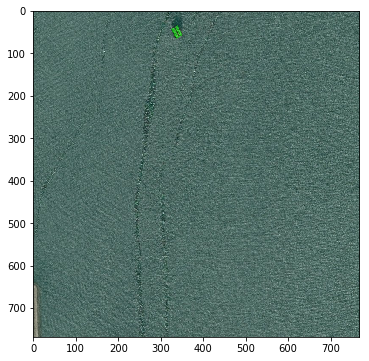

In [12]:
#To show image with its mask
imshow(*dataset_valid[0])

# Augment Data

We should create custom classes for sumultaneous transformation images and  masks

In [13]:
"""
    Implementation from  https://github.com/ternaus/robot-surgery-segmentation
"""

def clip(img, dtype, maxval):
    return np.clip(img, 0, maxval).astype(dtype)

class DualCompose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, x, mask=None):
        for t in self.transforms:
            x, mask = t(x, mask)
        return x, mask
    
class OneOf:
    def __init__(self, transforms, prob=0.5):
        self.transforms = transforms
        self.prob = prob

    def __call__(self, x, mask=None):
        if random.random() < self.prob:
            t = random.choice(self.transforms)
            t.prob = 1.
            x, mask = t(x, mask)
        return x, mask

class OneOrOther:
    def __init__(self, first, second, prob=0.5):
        self.first = first
        first.prob = 1.
        self.second = second
        second.prob = 1.
        self.prob = prob

    def __call__(self, x, mask=None):
        if random.random() < self.prob:
            x, mask = self.first(x, mask)
        else:
            x, mask = self.second(x, mask)
        return x, mask


class ImageOnly:
    def __init__(self, trans):
        self.trans = trans

    def __call__(self, x, mask=None):
        return self.trans(x), mask


class VerticalFlip:
    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, img, mask=None):
        if random.random() < self.prob:
            img = cv2.flip(img, 0)
            if mask is not None:
                mask = cv2.flip(mask, 0)
        return img, mask


class HorizontalFlip:
    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, img, mask=None):
        if random.random() < self.prob:
            img = cv2.flip(img, 1)
            if mask is not None:
                mask = cv2.flip(mask, 1)
        return img, mask


class RandomFlip:
    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, img, mask=None):
        if random.random() < self.prob:
            d = random.randint(-1, 1)
            img = cv2.flip(img, d)
            if mask is not None:
                mask = cv2.flip(mask, d)
        return img, mask


class Transpose:
    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, img, mask=None):
        if random.random() < self.prob:
            img = img.transpose(1, 0, 2)
            if mask is not None:
                mask = mask.transpose(1, 0, 2)
        return img, mask


class RandomRotate90:
    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, img, mask=None):
        if random.random() < self.prob:
            factor = random.randint(0, 4)
            img = np.rot90(img, factor)
            if mask is not None:
                mask = np.rot90(mask, factor)
        return img.copy(), mask.copy()


class Rotate:
    def __init__(self, limit=90, prob=0.5):
        self.prob = prob
        self.limit = limit

    def __call__(self, img, mask=None):
        if random.random() < self.prob:
            angle = random.uniform(-self.limit, self.limit)

            height, width = img.shape[0:2]
            mat = cv2.getRotationMatrix2D((width / 2, height / 2), angle, 1.0)
            img = cv2.warpAffine(img, mat, (height, width),
                                 flags=cv2.INTER_LINEAR,
                                 borderMode=cv2.BORDER_REFLECT_101)
            if mask is not None:
                mask = cv2.warpAffine(mask, mat, (height, width),
                                      flags=cv2.INTER_LINEAR,
                                      borderMode=cv2.BORDER_REFLECT_101)

        return img, mask


class RandomCrop:
    def __init__(self, size):
        self.h = size[0]
        self.w = size[1]

    def __call__(self, img, mask=None):
        height, width, _ = img.shape

        h_start = np.random.randint(0, height - self.h)
        w_start = np.random.randint(0, width - self.w)

        img = img[h_start: h_start + self.h, w_start: w_start + self.w,:]

        assert img.shape[0] == self.h
        assert img.shape[1] == self.w

        if mask is not None:
            if mask.ndim == 2:
                mask = np.expand_dims(mask, axis=2)
            mask = mask[h_start: h_start + self.h, w_start: w_start + self.w,:]

        return img, mask


class Shift:
    def __init__(self, limit=4, prob=.5):
        self.limit = limit
        self.prob = prob

    def __call__(self, img, mask=None):
        if random.random() < self.prob:
            limit = self.limit
            dx = round(random.uniform(-limit, limit))
            dy = round(random.uniform(-limit, limit))

            height, width, channel = img.shape
            y1 = limit + 1 + dy
            y2 = y1 + height
            x1 = limit + 1 + dx
            x2 = x1 + width

            img1 = cv2.copyMakeBorder(img, limit + 1, limit + 1, limit + 1, limit + 1,
                                      borderType=cv2.BORDER_REFLECT_101)
            img = img1[y1:y2, x1:x2, :]
            if mask is not None:
                msk1 = cv2.copyMakeBorder(mask, limit + 1, limit + 1, limit + 1, limit + 1,
                                          borderType=cv2.BORDER_REFLECT_101)
                mask = msk1[y1:y2, x1:x2, :]

        return img, mask


class ShiftScale:
    def __init__(self, limit=4, prob=.25):
        self.limit = limit
        self.prob = prob

    def __call__(self, img, mask=None):
        limit = self.limit
        if random.random() < self.prob:
            height, width, channel = img.shape
            assert (width == height)
            size0 = width
            size1 = width + 2 * limit
            size = round(random.uniform(size0, size1))

            dx = round(random.uniform(0, size1 - size))
            dy = round(random.uniform(0, size1 - size))

            y1 = dy
            y2 = y1 + size
            x1 = dx
            x2 = x1 + size

            img1 = cv2.copyMakeBorder(img, limit, limit, limit, limit, borderType=cv2.BORDER_REFLECT_101)
            img = (img1[y1:y2, x1:x2, :] if size == size0
            else cv2.resize(img1[y1:y2, x1:x2, :], (size0, size0), interpolation=cv2.INTER_LINEAR))

            if mask is not None:
                msk1 = cv2.copyMakeBorder(mask, limit, limit, limit, limit, borderType=cv2.BORDER_REFLECT_101)
                mask = (msk1[y1:y2, x1:x2, :] if size == size0
                else cv2.resize(msk1[y1:y2, x1:x2, :], (size0, size0), interpolation=cv2.INTER_LINEAR))

        return img, mask


class ShiftScaleRotate:
    def __init__(self, shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, prob=0.5):
        self.shift_limit = shift_limit
        self.scale_limit = scale_limit
        self.rotate_limit = rotate_limit
        self.prob = prob

    def __call__(self, img, mask=None):
        if random.random() < self.prob:
            height, width, channel = img.shape

            angle = random.uniform(-self.rotate_limit, self.rotate_limit)
            scale = random.uniform(1 - self.scale_limit, 1 + self.scale_limit)
            dx = round(random.uniform(-self.shift_limit, self.shift_limit)) * width
            dy = round(random.uniform(-self.shift_limit, self.shift_limit)) * height

            cc = math.cos(angle / 180 * math.pi) * scale
            ss = math.sin(angle / 180 * math.pi) * scale
            rotate_matrix = np.array([[cc, -ss], [ss, cc]])

            box0 = np.array([[0, 0], [width, 0], [width, height], [0, height], ])
            box1 = box0 - np.array([width / 2, height / 2])
            box1 = np.dot(box1, rotate_matrix.T) + np.array([width / 2 + dx, height / 2 + dy])

            box0 = box0.astype(np.float32)
            box1 = box1.astype(np.float32)
            mat = cv2.getPerspectiveTransform(box0, box1)
            img = cv2.warpPerspective(img, mat, (width, height),
                                      flags=cv2.INTER_LINEAR,
                                      borderMode=cv2.BORDER_REFLECT_101)
            if mask is not None:
                mask = cv2.warpPerspective(mask, mat, (width, height),
                                           flags=cv2.INTER_NEAREST,
                                           borderMode=cv2.BORDER_REFLECT_101)

        return img, mask


class CenterCrop:
    def __init__(self, size):
        self.height = size[0]
        self.width = size[1]

    def __call__(self, img, mask=None):
        h, w, c = img.shape
        dy = (h - self.height) // 2
        dx = (w - self.width) // 2
        y1 = dy
        y2 = y1 + self.height
        x1 = dx
        x2 = x1 + self.width
        img = img[y1:y2, x1:x2,:]
        if mask is not None:
            if mask.ndim == 2:
                mask = np.expand_dims(mask, axis=2)
            mask = mask[y1:y2, x1:x2,:]

        return img, mask
    
class RandomBrightness:
    def __init__(self, limit=0.1, prob=0.5):
        self.limit = limit
        self.prob = prob

    def __call__(self, img):
        if random.random() < self.prob:
            alpha = 1.0 + self.limit * random.uniform(-1, 1)

            maxval = np.max(img[..., :3])
            dtype = img.dtype
            img[..., :3] = clip(alpha * img[..., :3], dtype, maxval)
        return img


class RandomContrast:
    def __init__(self, limit=.1, prob=.5):
        self.limit = limit
        self.prob = prob

    def __call__(self, img):
        if random.random() < self.prob:
            alpha = 1.0 + self.limit * random.uniform(-1, 1)

            gray = cv2.cvtColor(img[:, :, :3], cv2.COLOR_BGR2GRAY)
            gray = (3.0 * (1.0 - alpha) / gray.size) * np.sum(gray)
            maxval = np.max(img[..., :3])
            dtype = img.dtype
            img[:, :, :3] = clip(alpha * img[:, :, :3] + gray, dtype, maxval)
        return img



In [14]:
train_transform = DualCompose([
        HorizontalFlip(),
        VerticalFlip(),
        RandomCrop((256,256,3)),
        #ImageOnly(RandomBrightness()),
        #ImageOnly(RandomContrast()),
])

val_transform = DualCompose([
        CenterCrop((512,512,3)),
      ])

## UNET model

In [15]:
# Implementation from https://github.com/timctho/unet-pytorch/
class UNet_down_block(torch.nn.Module):
    def __init__(self, input_channel, output_channel, down_size):
        super(UNet_down_block, self).__init__()
        self.conv1 = torch.nn.Conv2d(input_channel, output_channel, 3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(output_channel)
        self.conv2 = torch.nn.Conv2d(output_channel, output_channel, 3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(output_channel)
        self.conv3 = torch.nn.Conv2d(output_channel, output_channel, 3, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(output_channel)
        self.max_pool = torch.nn.MaxPool2d(2, 2)
        self.relu = torch.nn.ReLU()
        self.down_size = down_size

    def forward(self, x):
        if self.down_size:
            x = self.max_pool(x)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        return x

class UNet_up_block(torch.nn.Module):
    def __init__(self, prev_channel, input_channel, output_channel):
        super(UNet_up_block, self).__init__()
        self.up_sampling = torch.nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv1 = torch.nn.Conv2d(prev_channel + input_channel, output_channel, 3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(output_channel)
        self.conv2 = torch.nn.Conv2d(output_channel, output_channel, 3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(output_channel)
        self.conv3 = torch.nn.Conv2d(output_channel, output_channel, 3, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(output_channel)
        self.relu = torch.nn.ReLU()

    def forward(self, prev_feature_map, x):
        x = self.up_sampling(x)
        x = torch.cat((x, prev_feature_map), dim=1)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        return x


class UNet(torch.nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.down_block1 = UNet_down_block(3, 16, False)
        self.down_block2 = UNet_down_block(16, 32, True)
        self.down_block3 = UNet_down_block(32, 64, True)
        self.down_block4 = UNet_down_block(64, 128, True)
        self.down_block5 = UNet_down_block(128, 256, True)
        self.down_block6 = UNet_down_block(256, 512, True)
        self.down_block7 = UNet_down_block(512, 1024, True)

        self.mid_conv1 = torch.nn.Conv2d(1024, 1024, 3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(1024)
        self.mid_conv2 = torch.nn.Conv2d(1024, 1024, 3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(1024)
        self.mid_conv3 = torch.nn.Conv2d(1024, 1024, 3, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(1024)

        self.up_block1 = UNet_up_block(512, 1024, 512)
        self.up_block2 = UNet_up_block(256, 512, 256)
        self.up_block3 = UNet_up_block(128, 256, 128)
        self.up_block4 = UNet_up_block(64, 128, 64)
        self.up_block5 = UNet_up_block(32, 64, 32)
        self.up_block6 = UNet_up_block(16, 32, 16)

        self.last_conv1 = torch.nn.Conv2d(16, 16, 3, padding=1)
        self.last_bn = torch.nn.BatchNorm2d(16)
        self.last_conv2 = torch.nn.Conv2d(16, 1, 1, padding=0)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        self.x1 = self.down_block1(x)
        self.x2 = self.down_block2(self.x1)
        self.x3 = self.down_block3(self.x2)
        self.x4 = self.down_block4(self.x3)
        self.x5 = self.down_block5(self.x4)
        self.x6 = self.down_block6(self.x5)
        self.x7 = self.down_block7(self.x6)
        self.x7 = self.relu(self.bn1(self.mid_conv1(self.x7)))
        self.x7 = self.relu(self.bn2(self.mid_conv2(self.x7)))
        self.x7 = self.relu(self.bn3(self.mid_conv3(self.x7)))
        x = self.up_block1(self.x6, self.x7)
        x = self.up_block2(self.x5, x)
        x = self.up_block3(self.x4, x)
        x = self.up_block4(self.x3, x)
        x = self.up_block5(self.x2, x)
        x = self.up_block6(self.x1, x)
        x = self.relu(self.last_bn(self.last_conv1(x)))
        x = self.last_conv2(x)
        return x

## Loss function
Due to non-differentiability of the competition evaluation metric (F2 Score at different intersection over union (IoU) thresholds) we use combination of  the BinnaryCrossEntropy loss and minus Jaccard index (https://en.wikipedia.org/wiki/Jaccard_index)


In [16]:
 class LossBinary:
    """
     Implementation from  https://github.com/ternaus/robot-surgery-segmentation
    """

    def __init__(self, jaccard_weight=0):
        self.nll_loss = nn.BCEWithLogitsLoss()
        self.jaccard_weight = jaccard_weight

    def __call__(self, outputs, targets):
        loss = self.nll_loss(outputs, targets)

        if self.jaccard_weight:
            eps = 1e-15
            jaccard_target = (targets == 1.0).float()
            jaccard_output = F.sigmoid(outputs)

            intersection = (jaccard_output * jaccard_target).sum()
            union = jaccard_output.sum() + jaccard_target.sum()

            loss -= self.jaccard_weight * torch.log((intersection + eps) / (union - intersection + eps))
        return loss



## Validation routine

In [17]:
def validation(model: nn.Module, criterion, valid_loader):
    print("Validation on hold-out....")
    model.eval()
    losses = []
    jaccard = []
    for inputs, targets in valid_loader:
        inputs = variable(inputs, volatile=True)
        targets = variable(targets)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        losses.append(loss.data[0])
        jaccard += [get_jaccard(targets, (outputs > 0).float()).data[0]]

    valid_loss = np.mean(losses)  # type: float

    valid_jaccard = np.mean(jaccard)

    print('Valid loss: {:.5f}, jaccard: {:.5f}'.format(valid_loss, valid_jaccard))
    metrics = {'valid_loss': valid_loss, 'jaccard_loss': valid_jaccard}
    return metrics


def get_jaccard(y_true, y_pred):
    epsilon = 1e-15
    intersection = (y_pred * y_true).sum(dim=-2).sum(dim=-1).sum(dim = -1)
    union = y_true.sum(dim=-2).sum(dim=-1).sum(dim=-1) + y_pred.sum(dim=-2).sum(dim=-1).sum(dim = -1)

    return (intersection / (union - intersection + epsilon)).mean()

In [18]:
# sume helper functions
def variable(x, volatile=False):
    if isinstance(x, (list, tuple)):
        return [variable(y, volatile=volatile) for y in x]
    return cuda(Variable(x, volatile=volatile))

def cuda(x):
    return x.cuda(async=True) if torch.cuda.is_available() else x

def write_event(log, step: int, **data):
    data['step'] = step
    data['dt'] = datetime.now().isoformat()
    #data = data.tolist()
#     dictlist = []
#     for key,items in data.items():
#         temp = [key, items]
#         dictlist.append(temp)
#     log.write(json.dumps(dictlist))
    log.write('\n')
    log.flush()

## Train

In [19]:
# main train routine
# Implementation from  https://github.com/ternaus/robot-surgery-segmentation
def train(lr, model, criterion, train_loader, valid_loader, validation, init_optimizer, n_epochs=1, fold=1):
    optimizer = init_optimizer(lr)
    #model = nn.DataParallel(model, device_ids=None)
    if torch.cuda.is_available():
        model.cuda()
    model_path = Path('model_{fold}.pt'.format(fold=fold))
    if model_path.exists():
        state = torch.load(str(model_path))
        epoch = state['epoch']
        step = state['step']
        model.load_state_dict(state['model'])
        print('Restored model, epoch {}, step {:,}'.format(epoch, step))
    else:
        epoch = 1
        step = 0

    save = lambda ep: torch.save({
        'model': model.state_dict(),
        'epoch': ep,
        'step': step,
    }, str(model_path))


    report_each = 50
    log = open('train_{fold}.log'.format(fold=fold),'at', encoding='utf8')
    valid_losses = []
    for epoch in range(epoch, n_epochs + 1):
        model.train()
        random.seed()
        tq = tqdm(total=len(train_loader) *  BATCH_SIZE)
        tq.set_description('Epoch {}, lr {}'.format(epoch, lr))
        losses = []
        tl = train_loader
        try:
            mean_loss = 0
            for i, (inputs, targets) in enumerate(tl):
                inputs, targets = variable(inputs), variable(targets)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                optimizer.zero_grad()
                batch_size = inputs.size(0)
                loss.backward()
                optimizer.step()
                step += 1
                tq.update(batch_size)
                losses.append(loss.data[0])
                mean_loss = np.mean(losses[-report_each:])
                tq.set_postfix(loss='{:.5f}'.format(mean_loss))
                if i and i % report_each == 0:
                    write_event(log, step, loss=mean_loss)
            write_event(log, step, loss=mean_loss)
            tq.close()
            save(epoch + 1)
            valid_metrics = validation(model, criterion, valid_loader)
            write_event(log, step, **valid_metrics)
            valid_loss = valid_metrics['valid_loss']
            valid_losses.append(valid_loss)
        except KeyboardInterrupt:
            tq.close()
            print('Ctrl+C, saving snapshot')
            save(epoch)
            print('done.')
            return

In [20]:
def make_loader(in_df, batch_size, shuffle=False, transform=None):
        return DataLoader(
            dataset=ShipDataset(in_df, transform=transform),
            shuffle=shuffle,
            num_workers = 0,
            batch_size = batch_size,
            pin_memory=torch.cuda.is_available()
        )

train_loader = make_loader(train_df, batch_size =  BATCH_SIZE, shuffle=True, transform=train_transform)
valid_loader = make_loader(valid_df, batch_size = int(BATCH_SIZE / 2), transform=None)

In [ ]:
# run just 3 epoch
model = UNet()
train(init_optimizer=lambda lr: Adam(model.parameters(), lr=lr),
        lr = 1e-4,
        n_epochs = 3,
        model=model,
        criterion=LossBinary(jaccard_weight=5),
        train_loader=train_loader,
        valid_loader=valid_loader,
        validation=validation,
        )
        

## Log visualization

In [ ]:
log_file = 'train_1.log'
logs = pd.read_json(log_file, lines=True)

plt.figure(figsize=(26,6))
plt.subplot(1, 2, 1)
plt.plot(logs.step[logs.loss.notnull()],
            logs.loss[logs.loss.notnull()],
            label="on training set")
 
#plt.plot(logs.step[logs.valid_loss.notnull()],
#            logs.valid_loss[logs.valid_loss.notnull()],
#            label = "on validation set")
         
plt.xlabel('step')
plt.legend(loc='center left')
plt.tight_layout()
plt.show();



## Prediction for one image 

In [ ]:
model = UNet()
model_path ='model_1.pt'
state = torch.load(str(model_path))
state = {key.replace('module.', ''): value for key, value in state['model'].items()}
model.load_state_dict(state)
if torch.cuda.is_available():
    model.cuda()

model.eval()

In [ ]:
valid_ds  = ShipDataset(valid_df)
# to show gt image
imshow(*valid_ds[0])

In [ ]:
# predict and show prediction 
img,_ = valid_ds[0]
input_img = torch.unsqueeze(variable(img, volatile=True), dim=0)
mask = F.sigmoid(model(input_img))
out_mask = torch.squeeze(mask.data.cpu(), dim = 0)
imshow(img,out_mask)

## Prediction for Test images

For test purposes predict only for 5000 images. Prediction of the full set of images (88500 images) takes more than 6hr !!!

In [ ]:
test_paths = os.listdir(test_image_dir)
print(len(test_paths), 'test images found')

In [ ]:
test_df = pd.DataFrame({'ImageId': test_paths, 'EncodedPixels':None})
from skimage.morphology import binary_opening, disk
test_df=test_df[:5000]
loader = DataLoader(
        dataset=ShipDataset(test_df, transform=None, mode='predict'),
        shuffle=False,
        batch_size=BATCH_SIZE,
        num_workers=0,
        pin_memory=torch.cuda.is_available()
    ) 
    
out_pred_rows = []
for batch_num, (inputs, paths) in enumerate(tqdm(loader, desc='Predict')):
    inputs = variable(inputs, volatile=True)
    outputs = model(inputs)
    for i, image_name in enumerate(paths):
        mask = F.sigmoid(outputs[i,0]).data.cpu().numpy()
        cur_seg = binary_opening(mask>0.5, disk(2))
        cur_rles = multi_rle_encode(cur_seg)
        if len(cur_rles)>0:
            for c_rle in cur_rles:
                out_pred_rows += [{'ImageId': image_name, 'EncodedPixels': c_rle}]
        else:
            out_pred_rows += [{'ImageId': image_name, 'EncodedPixels': None}]


In [ ]:
submission_df = pd.DataFrame(out_pred_rows)[['ImageId', 'EncodedPixels']]
submission_df.to_csv('submission.csv', index=False)
submission_df.sample(10)